### features:
* selected spectogram coef
* zero crossing rate
* selected chromogram values
* selected tempogram values
* wavelet of level 0

In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, recall_score
import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassBalance, ROCAUC, ClassificationReport, ClassPredictionError
import itertools

In [2]:
csv_path = "/Users/ecem/Desktop/gyrocardiogram/preprocess_data"

## Load data

Here, our target is to predict disease correctly. So; our y will be disease column of  dataset

In [3]:
spec = pd.read_csv(csv_path + '/pvs-intersection-spec.csv', index_col = 0)
#spec  #uncomment to see dataframe

signal_proc = pd.read_csv(csv_path + '/signal_processing.csv', index_col = 0)
y = signal_proc.disease

zero_crossing = signal_proc.iloc[:,:21]
#zero_crossing #uncomment to see dataframe

tempogram = pd.read_csv(csv_path + '/pvs-tempogram-union.csv', index_col = 0)
#tempogram #uncomment to see dataframe

chromogram = pd.read_csv(csv_path + '/pvs-union-chromogram.csv', index_col = 0)
#chromogram #uncomment to see dataframe

w_lvl0 = pd.read_csv(csv_path + '/wavelet_lvl0.csv', index_col = 0).iloc[:,:-1]
#w_lvl0  #uncomment to see dataframe

In [4]:
y

0       MR
1       MR
2       MR
3       MR
4       MR
        ..
1351    AS
1352    AS
1353    AS
1354    AS
1355    AS
Name: disease, Length: 1356, dtype: object

In [5]:
features = pd.concat([spec, w_lvl0], axis = 1)
features = pd.concat([features, zero_crossing], axis = 1)
features = pd.concat([features, chromogram], axis = 1)
features = pd.concat([features, tempogram], axis = 1)

features

,freq_y1221,freq_z1221,freq_x1222,freq_y1222,freq_z1222,freq_x1223,freq_y1223,freq_z1223,freq_x1224,freq_y1224,...,tempogram_x320,tempogram_y320,tempogram_z320,tempogram_z321,tempogram_y347,tempogram_x348,tempogram_x352,tempogram_x354,tempogram_x361.1,tempogram_z381
0,0.014026,0.013999,0.013981,0.013951,0.014022,0.014187,0.014453,0.014822,0.015264,0.015896,...,8.727423e-08,1.954336e-08,1.871601e-09,1.982309e-17,1.373494e-17,9.927815e-18,6.790674e-18,2.751500e-17,4.852058e-17,-2.479715e-17
1,0.015405,0.015992,0.016581,0.017174,0.017696,0.018073,0.018281,0.018322,0.018224,0.018040,...,8.915791e-08,1.995497e-08,1.909290e-09,1.438934e-17,1.549789e-17,6.849859e-18,1.052664e-17,2.010704e-17,5.231238e-17,-5.587983e-18
2,0.016609,0.016916,0.017323,0.017854,0.018267,0.018491,0.018498,0.018295,0.017925,0.017474,...,9.700728e-08,2.174558e-08,2.083858e-09,4.609669e-17,2.637483e-17,-9.518720e-19,4.654262e-17,3.413615e-17,8.164942e-17,-2.432285e-17
3,0.020885,0.020870,0.021012,0.021085,0.021029,0.020823,0.020487,0.020105,0.019772,0.019452,...,9.519815e-08,2.125941e-08,2.032911e-09,2.034370e-17,-1.792514e-17,4.094538e-18,-7.365256e-18,8.901710e-18,5.936763e-17,-1.653175e-17
4,0.022094,0.022235,0.022077,0.021608,0.020878,0.019931,0.018794,0.017544,0.016320,0.015330,...,9.630758e-08,2.155036e-08,2.061402e-09,1.861191e-17,5.134703e-18,-3.892907e-18,1.496137e-17,4.125030e-17,6.153390e-17,-1.358711e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1351,0.008834,0.008703,0.008640,0.008656,0.008670,0.008682,0.008716,0.008846,0.009047,0.009295,...,9.514573e-08,2.136252e-08,2.049998e-09,2.101259e-17,-7.301974e-18,7.461034e-21,2.152497e-17,2.705626e-17,5.398507e-17,-3.327739e-17
1352,0.009016,0.008968,0.008968,0.009110,0.009300,0.009528,0.009727,0.009888,0.010040,0.010245,...,9.681752e-08,2.174255e-08,2.085542e-09,3.594063e-17,-1.646009e-17,-8.702274e-18,-2.287602e-17,1.024735e-18,8.706118e-17,-2.912417e-17
1353,0.006566,0.006657,0.006929,0.007282,0.007618,0.007904,0.008120,0.008259,0.008335,0.008392,...,9.611841e-08,2.156786e-08,2.068718e-09,2.423370e-17,-1.127280e-18,6.185212e-18,4.920945e-17,2.753413e-17,8.368139e-17,-4.069871e-17
1354,0.008850,0.008600,0.008461,0.008436,0.008575,0.008874,0.009285,0.009831,0.010457,0.011055,...,9.776432e-08,2.194320e-08,2.105013e-09,2.578664e-17,-1.638909e-18,6.262087e-18,1.429770e-17,2.378048e-17,6.692856e-17,-2.684088e-17


In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_encoded

array([2, 2, 2, ..., 1, 1, 1])

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(features, y_encoded, train_size=0.8, test_size=0.2,
                                                                random_state=42)

In [15]:
import xgboost as xgb
model  = xgb.XGBClassifier(random_state = 42, objective='multi:softprob', eval_metric = 'merror') 

# Fit the model
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='merror', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, ...)

In [16]:
predictions = model.predict(X_valid)

In [17]:
classes = ['AR', 'AS', 'MR', 'MS']

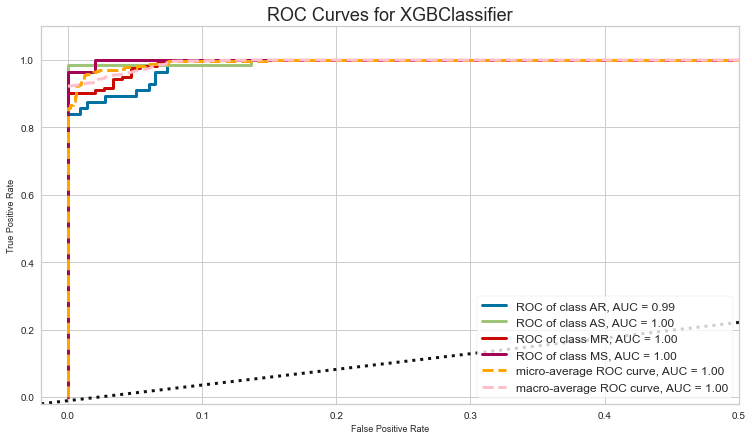

In [18]:
rocauc = ROCAUC(model, size=(900, 500), classes=classes )

rocauc.fit(X_train, y_train)       
rocauc.score(X_valid, y_valid)  
r = rocauc.poof()

/Users/ecem/miniforge3/envs/tf-metal/lib/python3.9/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


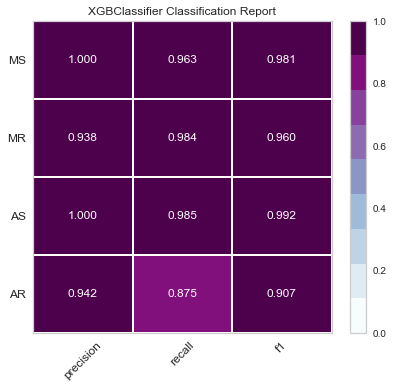

In [19]:
report = ClassificationReport(model, size=(425, 400), classes=classes, cmap = 'BuPu' )

report.score(X_valid, y_valid)
c = report.poof()

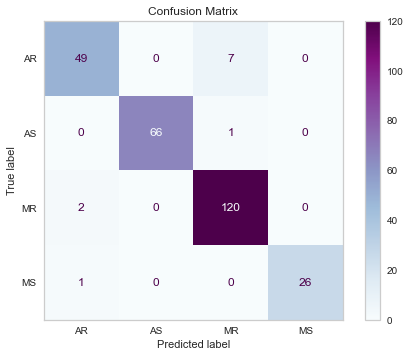

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
conf =  ConfusionMatrixDisplay.from_estimator(model, X_valid, y_valid, display_labels= ['AR', 'AS', 'MR', 'MS'], cmap = 'BuPu') 
conf.ax_.set_title("Confusion Matrix")
plt.grid(None)
plt.show()

In [21]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_valid, predictions)
print("accuracy: %.2f%%" % (accuracy * 100.0))

recall = recall_score(y_valid, predictions, average= 'weighted')
print("recall: %.2f%%" % (recall * 100.0))

from sklearn.metrics import precision_score
precision = precision_score(y_valid, predictions, average= 'weighted')
print("precision: %.2f%%" % (precision * 100.0))

accuracy: 95.96%
recall: 95.96%
precision: 96.01%


### with 0.0001 variation

In [22]:
vt = VarianceThreshold(threshold = 0.1)
_ = vt.fit(features)
masked = vt.get_support()
features_masked = features.loc[:, masked]
features_masked # uncomment to see the dataframe

,freq_x1230,freq_y1230,freq_z1230,freq_x1231,freq_y1231,freq_z1231,freq_x1232,freq_y1232,freq_z1232,freq_y1234,...,lvl0_z41,lvl0_z42,lvl0_z43,lvl0_z44,lvl0_z45,lvl0_z46,lvl0_z47,#ofcrossing_x,#ofcrossing_y,#ofcrossing_z
0,0.016587,0.016038,0.015803,0.015678,0.015659,0.015816,0.016174,0.016606,0.017018,0.018432,...,1.683546,1.953521,1.884336,3.337115,2.892143,2.902176,3.054463,315.0,563.0,309.0
1,0.015555,0.014908,0.014114,0.013242,0.012425,0.011731,0.011259,0.011137,0.011237,0.014197,...,2.536577,1.353387,1.348864,1.567292,1.382271,1.446645,1.549479,395.0,498.0,245.0
2,0.021837,0.021902,0.021718,0.021305,0.020735,0.020089,0.019337,0.018517,0.017701,0.013114,...,3.209004,-0.134956,1.253442,0.246203,0.389060,0.444405,0.397022,369.0,552.0,298.0
3,0.017253,0.016591,0.016218,0.016134,0.016155,0.016152,0.016067,0.015883,0.015625,0.015167,...,0.332423,2.512636,1.868316,1.286057,1.486791,1.487241,1.411369,322.0,525.0,291.0
4,0.016221,0.016060,0.015969,0.016074,0.016343,0.016606,0.016832,0.017040,0.017375,0.017936,...,2.255243,1.461551,1.337653,3.555023,3.041664,2.981505,3.120505,312.0,524.0,301.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1351,0.010704,0.010761,0.010886,0.011073,0.011309,0.011621,0.012053,0.012566,0.013057,0.014116,...,-0.206653,-0.175639,-0.956635,-0.977654,-0.954696,-0.949013,-0.922854,187.0,245.0,402.0
1352,0.009247,0.009588,0.009956,0.010337,0.010740,0.011155,0.011563,0.011961,0.012342,0.012534,...,0.619744,0.322873,0.318044,-0.032990,0.007116,0.036962,0.042782,161.0,204.0,431.0
1353,0.010340,0.010488,0.010620,0.010789,0.011056,0.011371,0.011674,0.011917,0.012065,0.011124,...,-0.542842,-0.112488,-0.638902,-1.010991,-0.917975,-0.897326,-0.906142,175.0,223.0,473.0
1354,0.010632,0.010995,0.011382,0.011759,0.012151,0.012536,0.012849,0.013063,0.013180,0.011671,...,0.329681,-0.059718,0.213193,0.465949,0.449462,0.418689,0.400873,161.0,202.0,434.0


In [23]:
X_train_, X_valid_, y_train_, y_valid_ = train_test_split(features_masked, y_encoded, train_size=0.8, test_size=0.2,
                                                                random_state=42)

In [24]:
import xgboost as xgb
model_  = xgb.XGBClassifier(random_state = 42, eval_metric = 'merror', objective='multi:softprob' ) 

# Fit the model
model_.fit(X_train_, y_train_)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='merror', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, ...)

In [25]:
predictions_ = model_.predict(X_valid_)

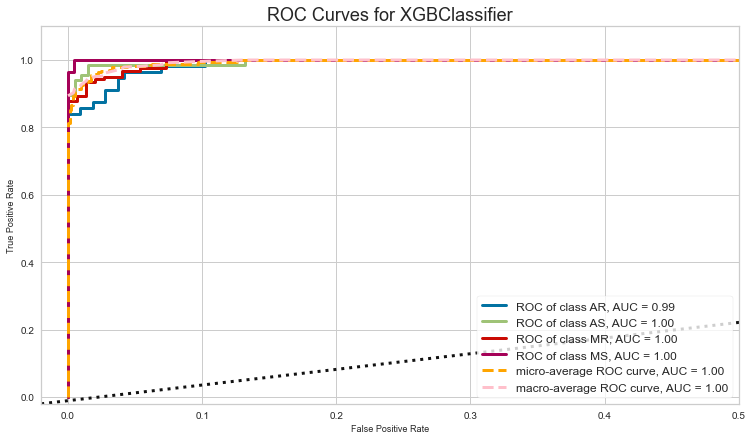

In [26]:
rocauc_ = ROCAUC(model_, size=(900, 500), classes=classes)

rocauc_.fit(X_train_, y_train_)       
rocauc_.score(X_valid_, y_valid_)  
r = rocauc_.poof()

In [27]:
c

<AxesSubplot:title={'center':'XGBClassifier Classification Report'}>

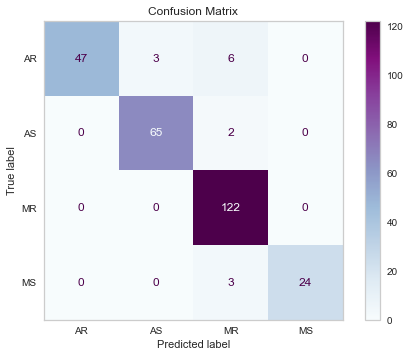

In [28]:
conf_ =  ConfusionMatrixDisplay.from_estimator(model_, X_valid_, y_valid_, display_labels= ['AR', 'AS', 'MR', 'MS'], cmap = 'BuPu')   
conf_.ax_.set_title("Confusion Matrix")
plt.grid(None)
plt.show()

In [29]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_valid_, predictions_)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 94.85%


In [30]:
recall = recall_score(y_valid_, predictions_, average= 'weighted')
print("recall: %.2f%%" % (recall * 100.0))

from sklearn.metrics import precision_score
precision = precision_score(y_valid_, predictions_, average= 'weighted')
print("precision: %.2f%%" % (precision * 100.0))

recall: 94.85%
precision: 95.20%
